<a href="https://colab.research.google.com/github/nathanbarry474/google-colab-notebooks/blob/master/FirstGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting it up

In [ ]:
# Importing the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Mini-batch size
batch_size = 64

# Transform
transform = transforms.Compose([transforms.ToTensor()])

# Downloading the dataset
trainset = datasets.MNIST(root='./data', download=True, train=True, transform=transform )

# Create Dataloader
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Visualizing the Data

torch.Size([64, 784])
784
(3, 242, 242)


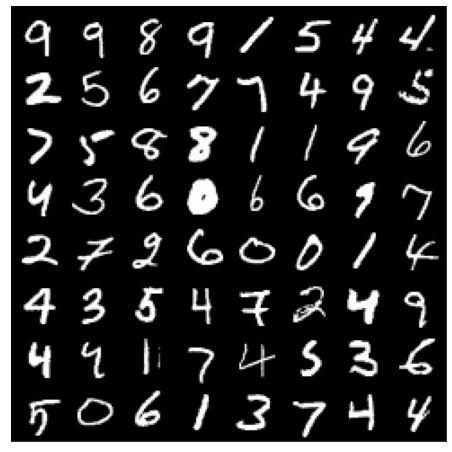

In [ ]:
# Defining an iterator
data_iter = iter(trainloader)

# Getting the next batch of the images and labels
images, labels = data_iter.next()
test = images.view(images.size(0), -1)
print(test.size())

Z_dim = 100
X_dim = test.size(1)

def imshow(img):
  im = make_grid(img)
  nping = im.numpy()
  print(nping.shape)
  plt.figure(figsize=(8, 8))
  plt.imshow(np.transpose(nping, (1, 2, 0)))
  plt.xticks([])
  plt.yticks([])
  plt.show

imshow(images)

In [ ]:
# Define weight initialization
def init_weight(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0)

# Number of hidden layers
h_dim = 128

# Creating the Generator
class Gen(nn.Module):
  def __init__(self):
    super(Gen, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(Z_dim, h_dim),
        nn.ReLU(),
        nn.Linear(h_dim, X_dim),
        nn.Sigmoid()
    )
    self.model.apply(init_weight)
  def forward(self, input):
    return self.model(input)

test = Gen()
print(test)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
# Creating the Discriminator
class Dis(nn.Module):
  def __init__(self):
    super(Dis, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(X_dim, h_dim),
        nn.ReLU(),
        nn.Linear(h_dim, 1),
        nn.Sigmoid()
    )
    self.model.apply(init_weight)
  def forward(self, input):
    return self.model(input)

test = Dis()
print(test)

Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
# Initializing the Gen and Dis
gen = Gen()
dis = Dis()

lr = 1e-3

Gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)
Dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr)

Epoch: 0, Gen_loss: 2.122437973520649, Dis_loss: 0.7483535186250581
(3, 122, 242)


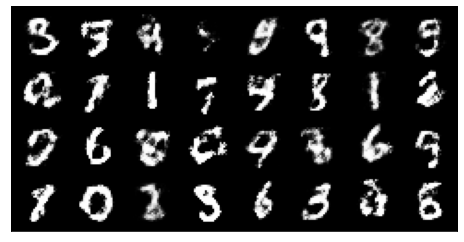

In [ ]:
epochs = 1

# Training for loop
for epoch in range(epochs):
  Gen_loss_run = 0.0
  Dis_loss_run = 0.0
  for i, data in enumerate(trainloader):
    X, _ = data
    mb_size = X.size(0)
    X = X.view(X.size(0), -1)

    # Defining labels for real (1s) and fake (0s) images
    one_labels = torch.ones(mb_size, 1)
    zero_labels = torch.zeros(mb_size, 1)

    # Random normal distribution for each generated image
    z = torch.randn(mb_size, Z_dim)

    # Feed forward in discriminator 
    Gen_sample = gen(z)
    Dis_fake = dis(Gen_sample)
    Dis_real = dis(X)

    # Defining the Loss for the discriminator
    Dis_fake_loss = F.binary_cross_entropy(Dis_fake, zero_labels)
    Dis_real_loss = F.binary_cross_entropy(Dis_real, one_labels)
    Dis_loss = Dis_fake_loss + Dis_real_loss

    ## backwards propagation for the discriminator
    Dis_optimizer.zero_grad()
    Dis_loss.backward()
    Dis_optimizer.step()

    # Feed forward for generator
    z = torch.randn(mb_size, Z_dim)
    Gen_sample = gen(z)
    Dis_fake = dis(Gen_sample)

    # Loss function of generator
    Gen_loss = F.binary_cross_entropy(Dis_fake, one_labels)

    # backward propagation for generator
    Gen_optimizer.zero_grad()
    Gen_loss.backward()
    Gen_optimizer.step()

    # Update loss tracker
    Gen_loss_run += Gen_loss.item()
    Dis_loss_run += Dis_loss.item()

  # Printing the loss after each epoch
  print('Epoch: {}, Gen_loss: {}, Dis_loss: {}'.format(epoch, Gen_loss_run/(i+1), Dis_loss_run/(i+1)))

  # Plotting fake images generated after each epoch by generator
  samples = gen(z).detach()
  samples = samples.view(samples.size(0), 1, 28, 28)
  imshow(samples)
